In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import mediapipe as mp

In [2]:
def resize_and_show(image, target_ht=480, target_wt=480):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (target_wt, math.floor(h / (w / target_wt))))
    else:
        img = cv2.resize(image, (math.floor(w / (h / target_ht)), target_ht))
    # set size
    plt.figure(figsize=(10,10))
    plt.axis("off")
    # convert color from CV2 BGR back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

face.jpg


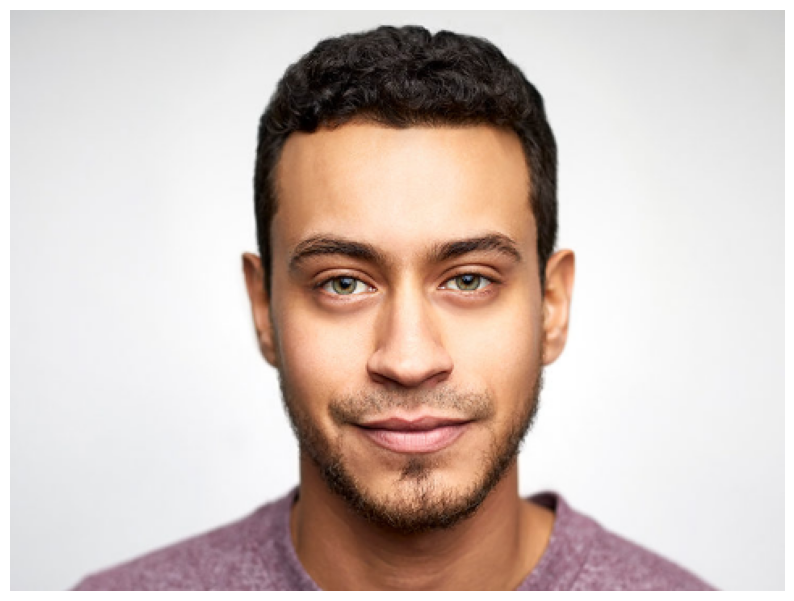

In [3]:
# Preview the images.
images = {name: cv2.imread(name) for name in ["face.jpg"]}
for name, image in images.items():
    print(name)   
    resize_and_show(image)

Face detections of face.jpg:


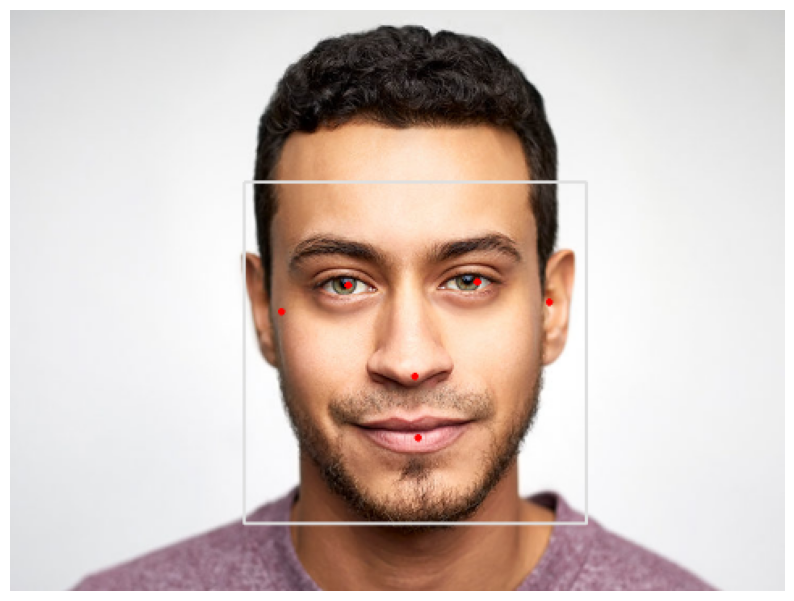

In [4]:
# Mediapipe

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Run MediaPipe Face Detection with short range model.
with mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=0) as face_detection:
    for name, image in images.items():
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Draw face detections of each face.
        print(f'Face detections of {name}:')
        if not results.detections:
            continue
        annotated_image = image.copy()
        for detection in results.detections:
            mp_drawing.draw_detection(annotated_image, detection)
        resize_and_show(annotated_image)

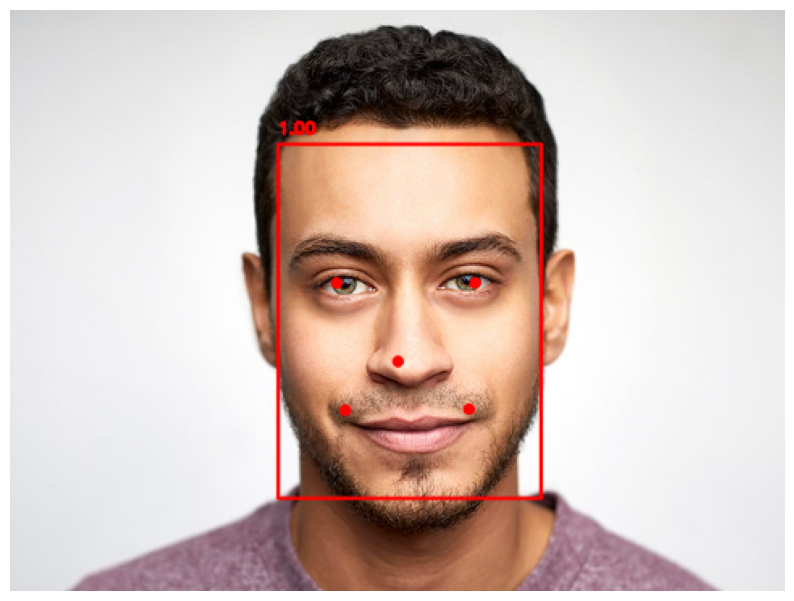

In [5]:
yn_face_detector = cv2.FaceDetectorYN_create("face_detection_yunet_2022mar.onnx", "", (0, 0))

for name, image in images.items():
    # Load image into YuNet face detctor
    height, width, _ = image.shape
    yn_face_detector.setInputSize((width, height))
    _, faces = yn_face_detector.detect(image)
    faces = faces if faces is not None else []

    # Draw box for each face found
    for face in faces:
        box = list(map(int, face[:4]))
        color = (0, 0, 255)
        thickness = 2
        cv2.rectangle(image, box, color, thickness, cv2.LINE_AA)

        landmarks = list(map(int, face[4:len(face)-1]))
        landmarks = np.array_split(landmarks, len(landmarks) / 2)
        for landmark in landmarks:
            radius = 5
            thickness = -1
            cv2.circle(image, landmark, radius, color, thickness, cv2.LINE_AA)

        confidence = face[-1]
        confidence = "{:.2f}".format(confidence)
        position = (box[0], box[1] - 10)
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.5
        thickness = 2
        cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)

    resize_and_show(image)

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
def fgsm_attack(image, epsilon, data_grad):
    image = image / 255
    image = torch.from_numpy(image)
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad#.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    perturbed_image = perturbed_image.numpy()
    perturbed_image = perturbed_image * 255
    return perturbed_image.astype(np.uint8)

In [7]:
def min_model_eps(image, data_grad, det_fn, start = 0.1, end = 3, step = 0.05):
    eps = start
    while True:
        perturbed_img = fgsm_attack(image, eps, data_grad)
        if not det_fn(perturbed_img) or eps >= end:
            break
        else:
            eps += 0.05
    while True:
        perturbed_img = fgsm_attack(image, eps, data_grad)
        if det_fn(perturbed_img) or eps <= start:
            break
        else:
            eps -= 0.01
    return eps + 0.01

In [8]:
def mp_det_fn(image):
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=0) as face_detection:
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        return results.detections is not None
    
def yn_det_fn(image):
    height, width, _ = image.shape
    yn_face_detector.setInputSize((width, height))
    _, faces = yn_face_detector.detect(image)
    return faces is not None

(549, 732, 3) (549, 732, 3)


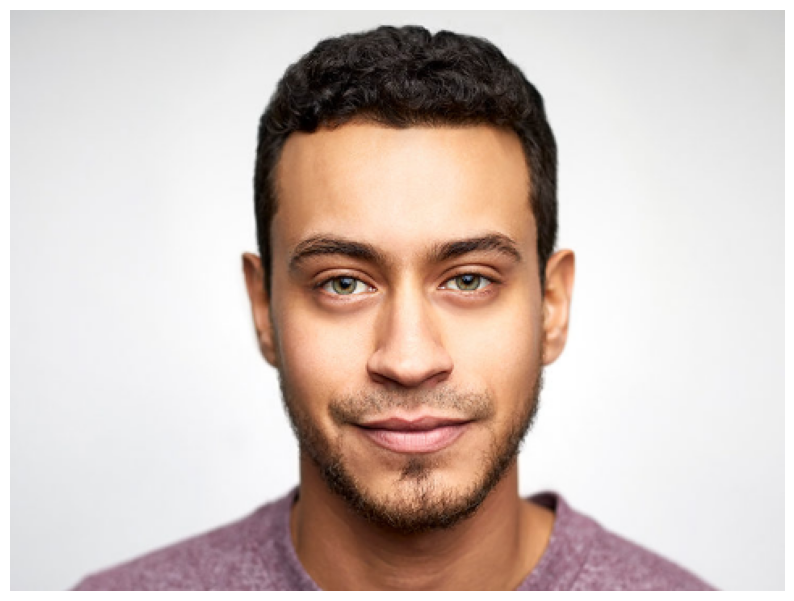

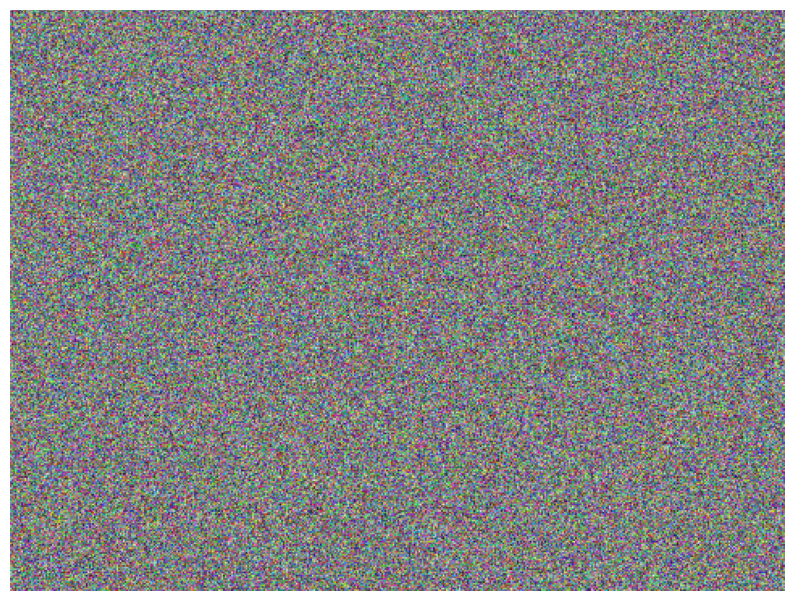

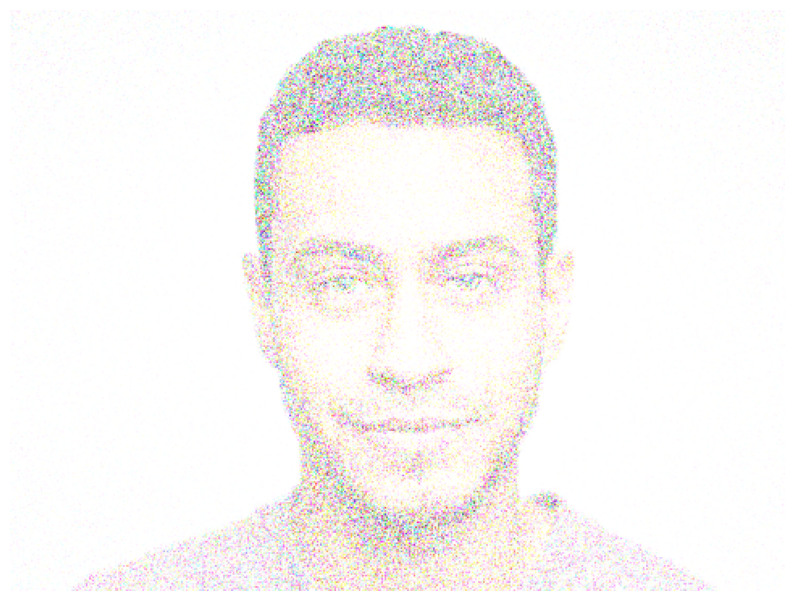

(1, array([[253.95602 , 111.22566 , 242.66864 , 325.0364  , 314.66013 ,
        251.50487 , 425.46616 , 255.53062 , 368.57455 , 325.89526 ,
        320.8846  , 381.40137 , 408.7109  , 384.31613 ,   0.914439]],
      dtype=float32))
(1, array([[253.06915 , 127.955505, 249.4298  , 335.51764 , 308.55228 ,
        258.87387 , 439.66183 , 258.00342 , 366.78387 , 332.16312 ,
        316.21573 , 378.36636 , 433.01282 , 377.68054 ,   1.      ]],
      dtype=float32))
False


In [9]:
test_img = cv2.imread("face.jpg")

np.random.seed(42)
noise = np.random.uniform(0, 1, size=test_img.shape)

perturbed_img = fgsm_attack(test_img, 2.13, noise)

print(test_img.shape, noise.shape)

resize_and_show(test_img)
resize_and_show((noise * 255).astype(np.uint8))
resize_and_show(perturbed_img)

height, width, _ = perturbed_img.shape
yn_face_detector.setInputSize((width, height))

print(yn_face_detector.detect(perturbed_img))
print(yn_face_detector.detect(test_img))

print(mp_det_fn(perturbed_img))


In [10]:
min_model_eps(test_img, noise, mp_det_fn)

2.130000000000001

In [11]:
min_model_eps(test_img, noise, yn_det_fn)

2.2600000000000007

___

In [12]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)